# Preface
This notebook uses several packages from CRAN, as well as [Bioconductor](https://bioconductor.org). For a full list of attached packages see the session info in the Appendix at the end of this notebook. Several options have been adjusted to improve appearance of plots.

In [2]:
## Load necessary packages
suppressMessages({
    
    library("xcms")
    library("CAMERA")
    library("RColorBrewer")
    library("SummarizedExperiment")
    library("tidyverse")
    library("gplots")
    library("ggrepel")
    library("Rtsne")
    library("caret")
    library("MASS")
    
})

## Set session-specific options
options(repr.plot.width = 12, # Adjust plot width for publication purposes
        repr.plot.height = 8, # Adjust plot height for publication purposes,
        scipen = -1) # Adjust scientific notation of numbers to improve readability of plots

## List mzXML files
mzXMLs <- list.files(path = getwd(), recursive = TRUE, 
                     full.names = TRUE, pattern = ".mzXML")

# Quality Control of Raw Data
The following injection order during analysis correspond to the order files are read using list.files. In case several batches were analysed, as vector containing an integer for each batch assignment of each sample must be given.

In [3]:
## List mzXML files
mzXMLs <- list.files(path = "HILIC_pos", recursive = TRUE, 
                     full.names = TRUE, pattern = ".mzXML")

## Aggregate meta data
sample.name <- sub(basename(mzXMLs), pattern = ".mzXML", 
                   replacement = "", fixed = TRUE)
sample.group <- c(rep("Control", 5), rep("alpha-PCYP", 5), 
                  rep("QC", 7))
sample.order <- c(8,10,15,7,13,16,12,9,14,6,1,2,3,4,5,11,17)
sample.batch <- NA
meta <- data.frame(sample_name = sample.name, 
                   sample_group = sample.group, 
                   sample_order = sample.order, 
                   sample_batch = sample.batch, 
                   stringsAsFactors = FALSE)

## Read raw data from disk
raw <- readMSData(files = mzXMLs[order(sample.order)], 
                  pdata = new("AnnotatedDataFrame", 
                              meta[order(sample.order),]), 
                  mode = "onDisk")
## Remove column equilibration and washing phases
raw <- filterRt(raw, c(60,600))

class(raw)

print(raw)

[1] "OnDiskMSnExp"
attr(,"package")
[1] "MSnbase"

MSn experiment data ("OnDiskMSnExp")
Object size in memory: 4.99 Mb
- - - Spectra data - - -
 MS level(s): 1 
 Number of spectra: 17695 
 MSn retention times: 1:0 - 9:60 minutes
- - - Processing information - - -
Data loaded [Fri Oct 22 11:20:46 2021] 
Filter: select retention time [60-600] and MS level(s), 1 [Fri Oct 22 11:20:46 2021] 
 MSnbase version: 2.14.2 
- - - Meta data  - - -
phenoData
  rowNames: 11 12 ... 17 (17 total)
  varLabels: sample_name sample_group sample_order sample_batch
  varMetadata: labelDescription
Loaded from:
  [1] pQC_1.mzXML...  [17] pQC_7.mzXML
  Use 'fileNames(.)' to see all files.
protocolData: none
featureData
  featureNames: F01.S0117 F01.S0118 ... F17.S1157 (17695 total)
  fvarLabels: fileIdx spIdx ... spectrum (35 total)
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'


# Inspection of Parent Compound and Internal Standard
This experiment used deuterated tryptophan as an internal standard to normalise variability introduced by injection of the samples into the mass spectrometer. Quality control in at this stage includes ensuring that both the internal standard, as well as the parent compound, have been detected properly and the within group variability is acceptable.

In [4]:
## Define colours for experimental groups
group.colours <- paste0(brewer.pal(3, "Set1")[1:3])
names(group.colours) <- c("Control", "alpha-PCYP", "QC")

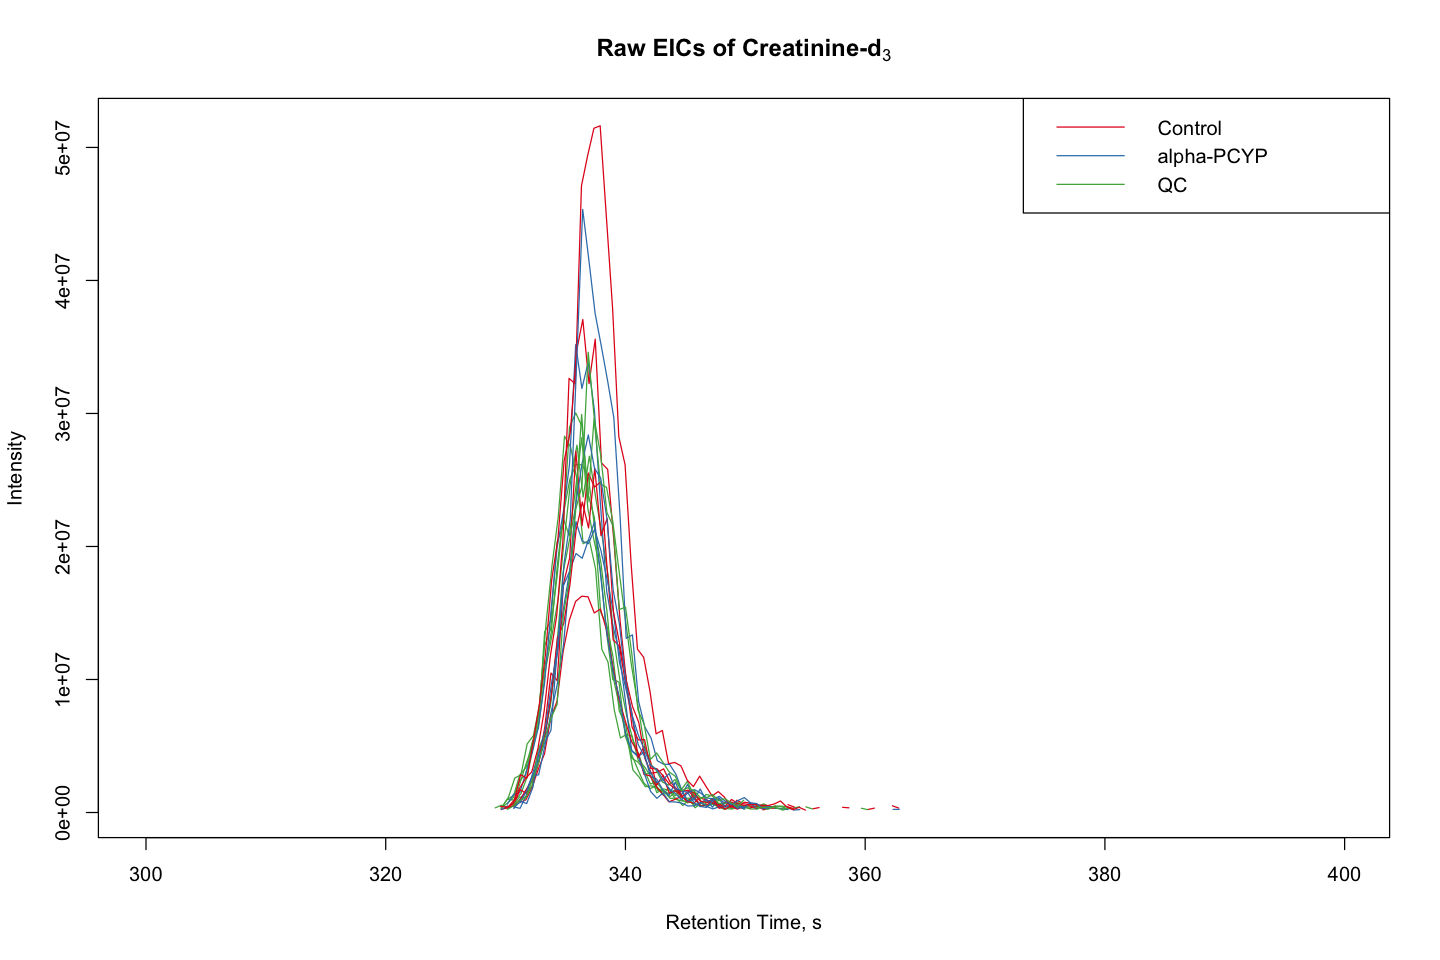

In [6]:
## Plot raw EICs of creatinine-d3 (m/z 117.0856, 25 s)
cread3.raw <- chromatogram(raw, mz = c(117.0841, 117.0871), rt = c(300, 400))

plot(cread3.raw, col = group.colours[cread3.raw$sample_group], 
     main = bquote(bold("Raw EICs of Creatinine-d"[3])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

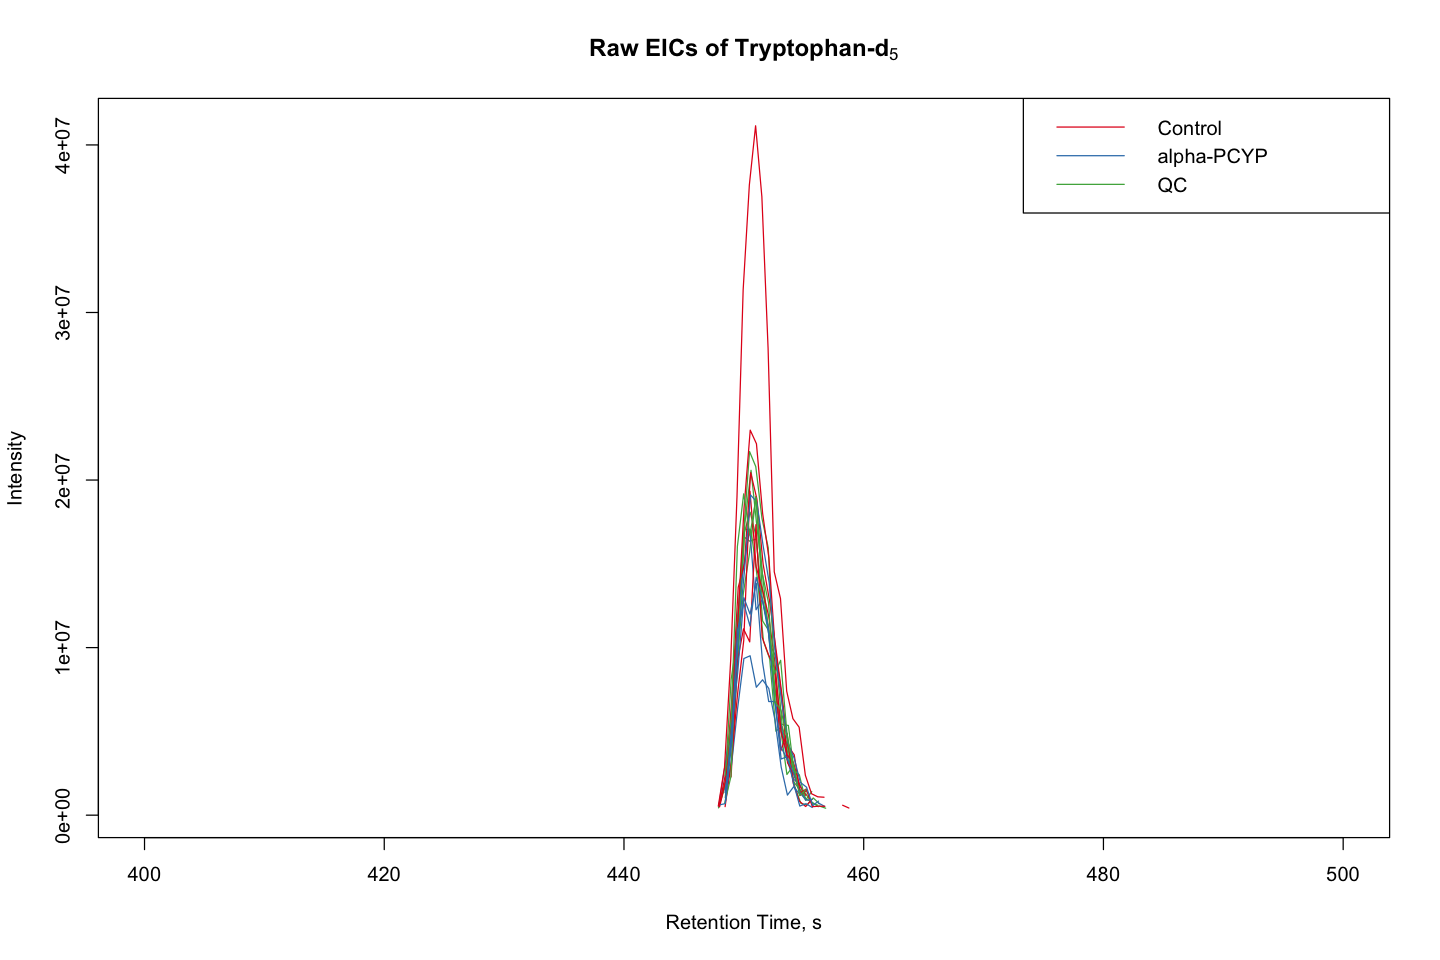

In [9]:
## Define colours for experimental groups
group.colours <- paste0(brewer.pal(3, "Set1")[1:3])
names(group.colours) <- c("Control", "alpha-PCYP", "QC")


## Plot tryptophan-d5 before processing (m/z 210.1291, 168 s)
trpd5.raw <- chromatogram(raw, mz = c(210.1281, 210.1296), rt = c(400, 500))

plot(trpd5.raw, col = group.colours[trpd5.raw$sample_group], 
     main = bquote(bold("Raw EICs of Tryptophan-d"[5])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

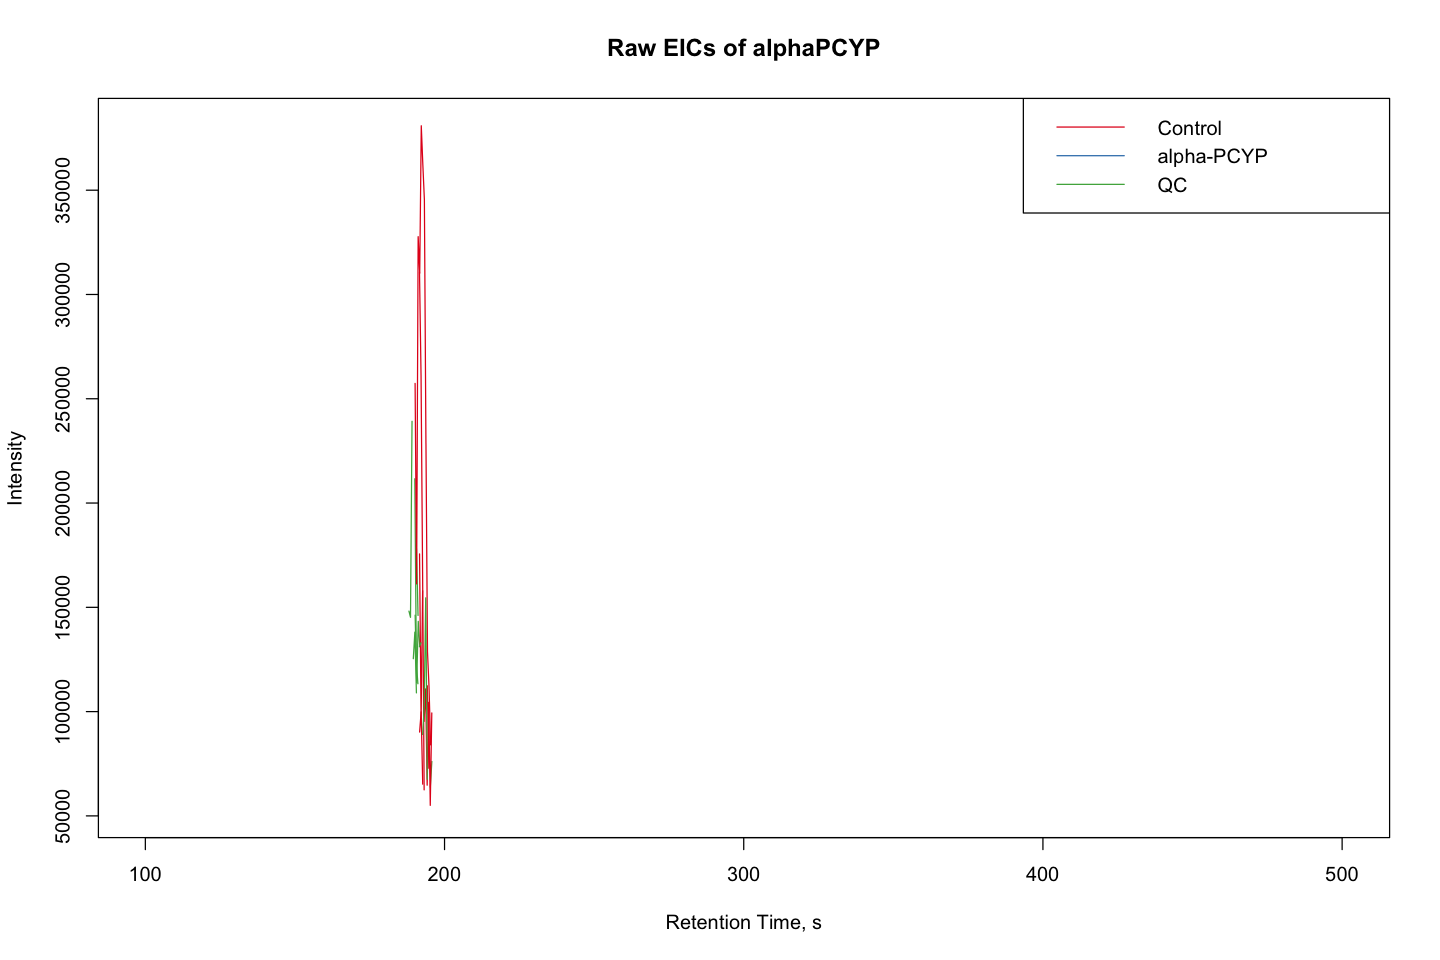

In [10]:
## Plot raw EICs of alpha-PCYP (m/z 272.2008, 25 s)
alphaPCYP.raw <- chromatogram(raw, mz = c(272.2000, 272.2015), rt = c(100, 500))

plot(alphaPCYP.raw, col = group.colours[alphaPCYP.raw$sample_group], 
     main = bquote(bold("Raw EICs of alphaPCYP")), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

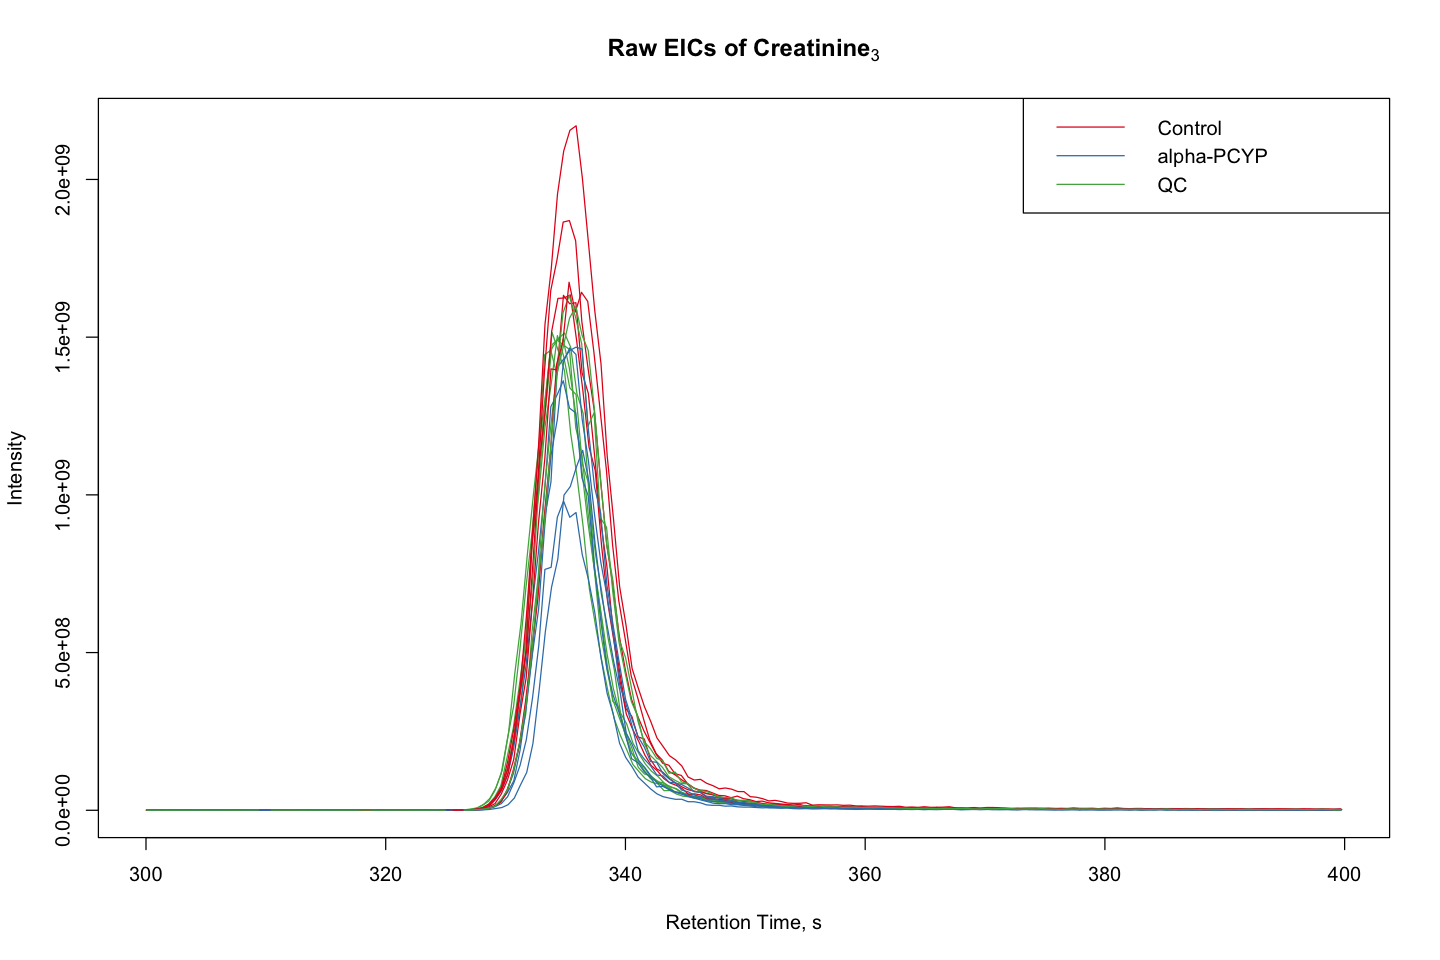

In [12]:
## Plot raw EICs of creatinine (m/z 114.0665, 25 s)
crea.raw <- chromatogram(raw, mz = c(114.0645, 114.0685), rt = c(300, 400))

plot(crea.raw, col = group.colours[crea.raw$sample_group], 
     main = bquote(bold("Raw EICs of Creatinine"[3])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Inspect Total Ion Currents of Sample Files

Total ion currents (TICs) need to be inspected in order to ensure that chromatography and mass spectrometry have been performing properly. Quality control includes the inspection of retention time drifts within TICS and evaluation of the baselines.

In [13]:
## Get total ion chromatograms
tics <- chromatogram(raw, aggregationFun = "sum")

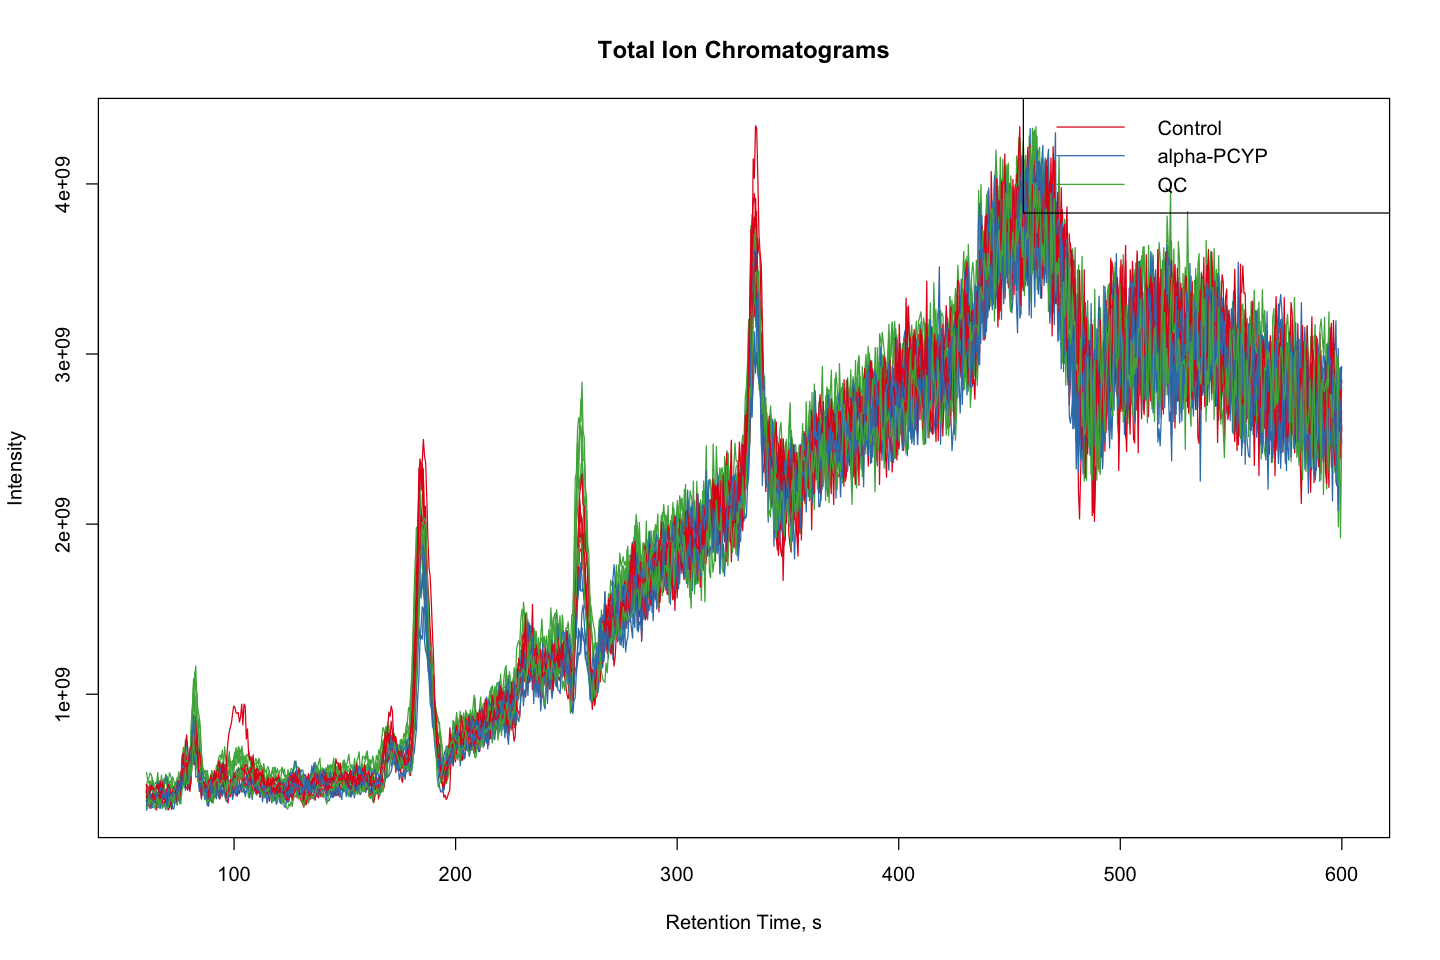

In [14]:
## Plot every total ion chromatogram of the data set
plot(tics, col = group.colours[raw$sample_group], 
     main = "Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

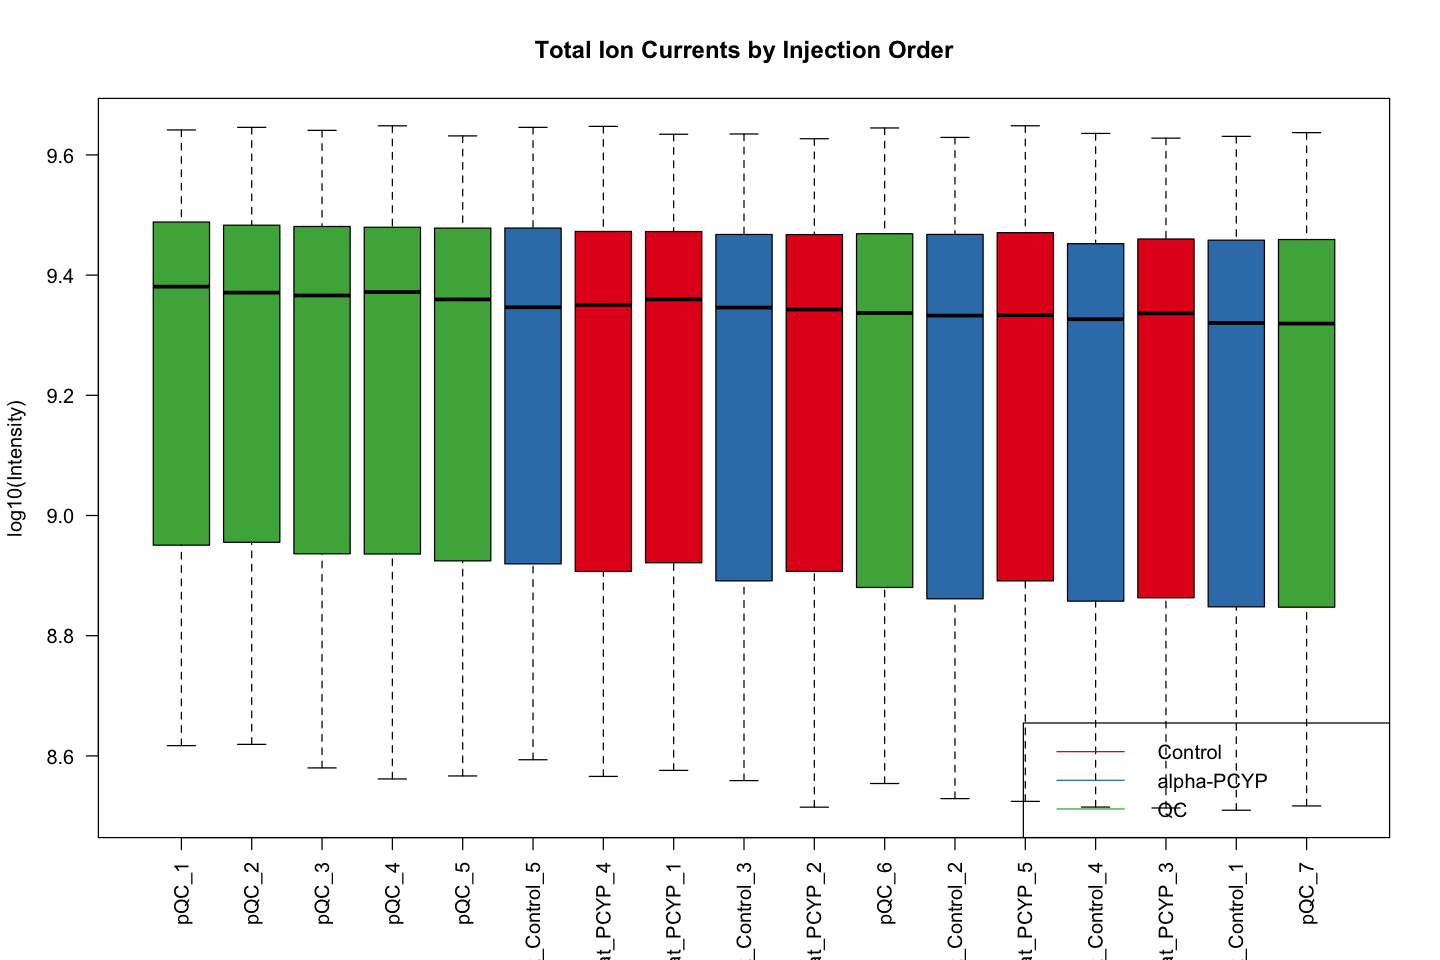

In [15]:
# Inspect boxplots of TICs by injection order
tics.summary <- split(tic(raw), f = fromFile(raw))

boxplot(sapply(tics.summary, log10), names = raw$sample_name, 
        col = group.colours[raw$sample_group], ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Injection Order", las = 2)
legend("bottomright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Preprocessing of Raw Sample Files

# Peak Picking

Parameter used in this section were obtained using the one-by-one optimization performed by centWaveOpt. This approach was published at DOI: 10.1002/dta.2552 by Manier et al.

In [16]:
cwp <- CentWaveParam(peakwidth = c(9, 20), ppm = 2.5, snthresh = 14, 
                     mzdiff = 0.0059,  prefilter = c(7, 100))

suppressMessages(
    
    set <- findChromPeaks(raw, param = cwp)
    
    )

In [17]:
## Define sample colours
sample.colours <- paste0(brewer.pal(3, "Set1")[1:3], "60")
names(sample.colours) <- c("Control", "alpha-PCYP", "QC")
sample.colours <- sample.colours[raw$sample_group]

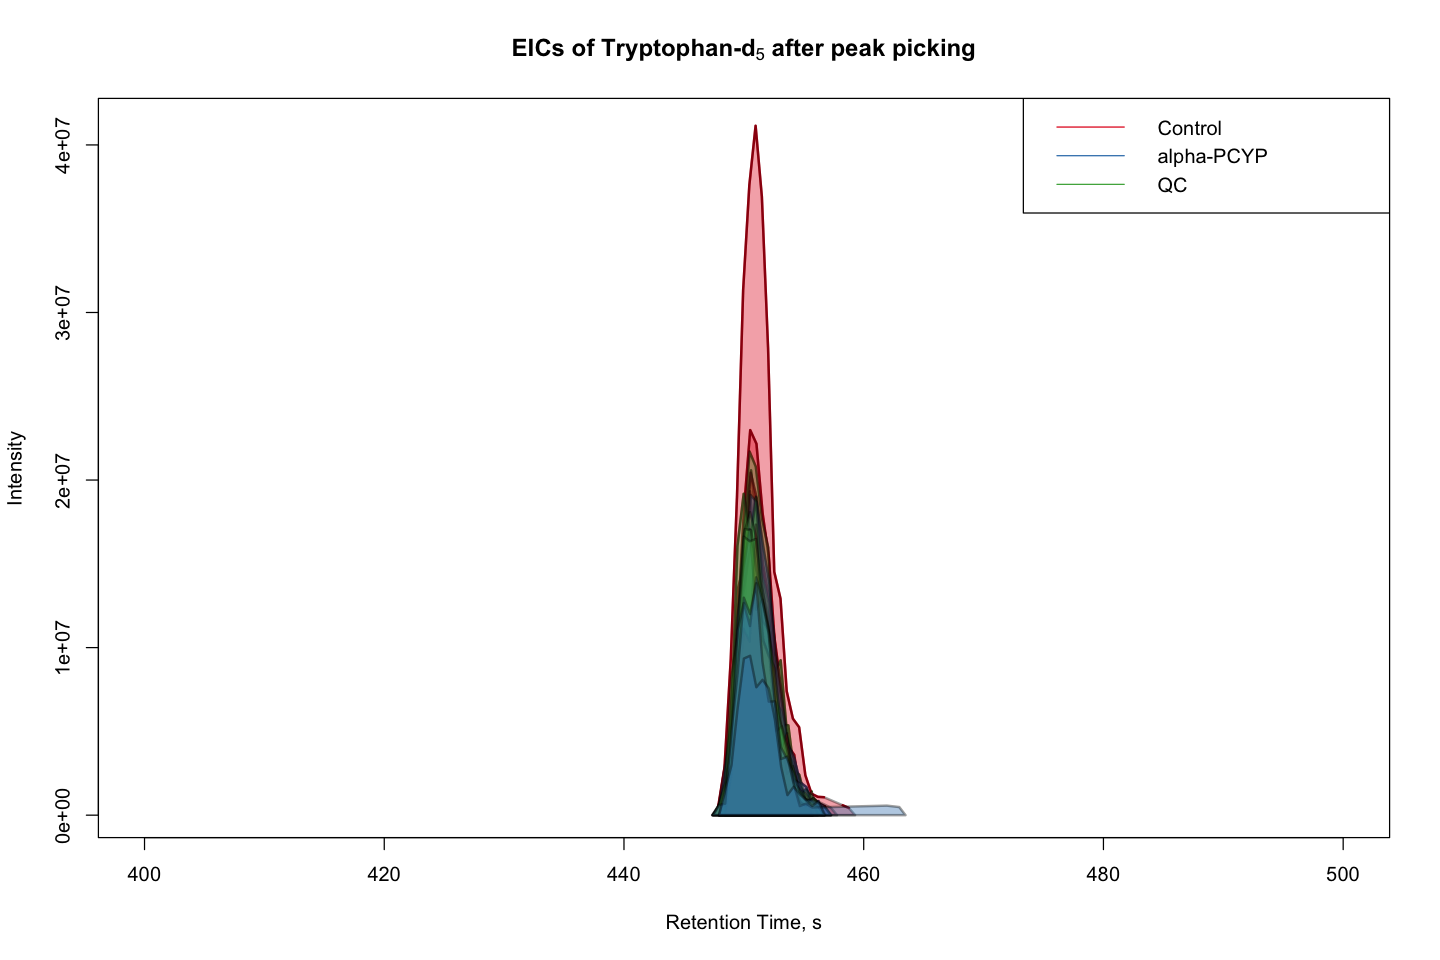

In [19]:
## Plot Tryptophan-d5 after peak picking (m/z 210.1291, 168 s)
trpd5.picked <- chromatogram(set, mz = c(210.1281, 210.1301), rt = c(400, 500)) 

plot(trpd5.picked, col = group.colours[trpd5.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(trpd5.picked)[, "sample"]],
     main = bquote(bold("EICs of Tryptophan-d"[5]*" after peak picking")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

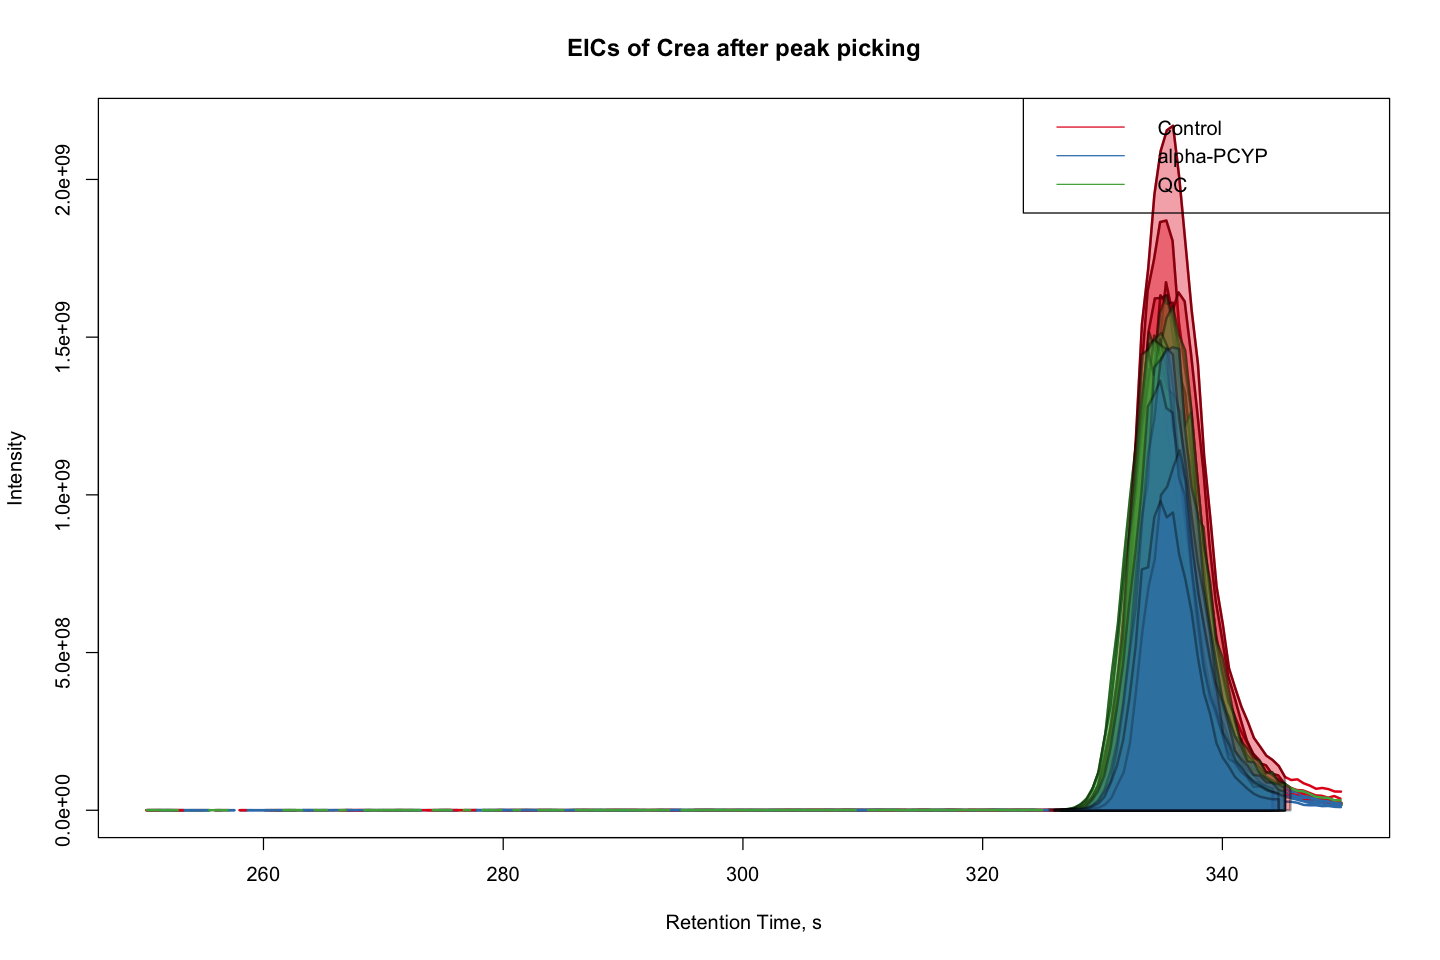

In [20]:
## Plot Crea after peak picking (m/z 114.0665, 287s)
crea.picked <- chromatogram(set, mz = c(114.0645, 114.0685), rt = c(250, 350)) 

plot(crea.picked, col = group.colours[crea.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(crea.picked)[, "sample"]],
     main = bquote(bold("EICs of Crea after peak picking")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

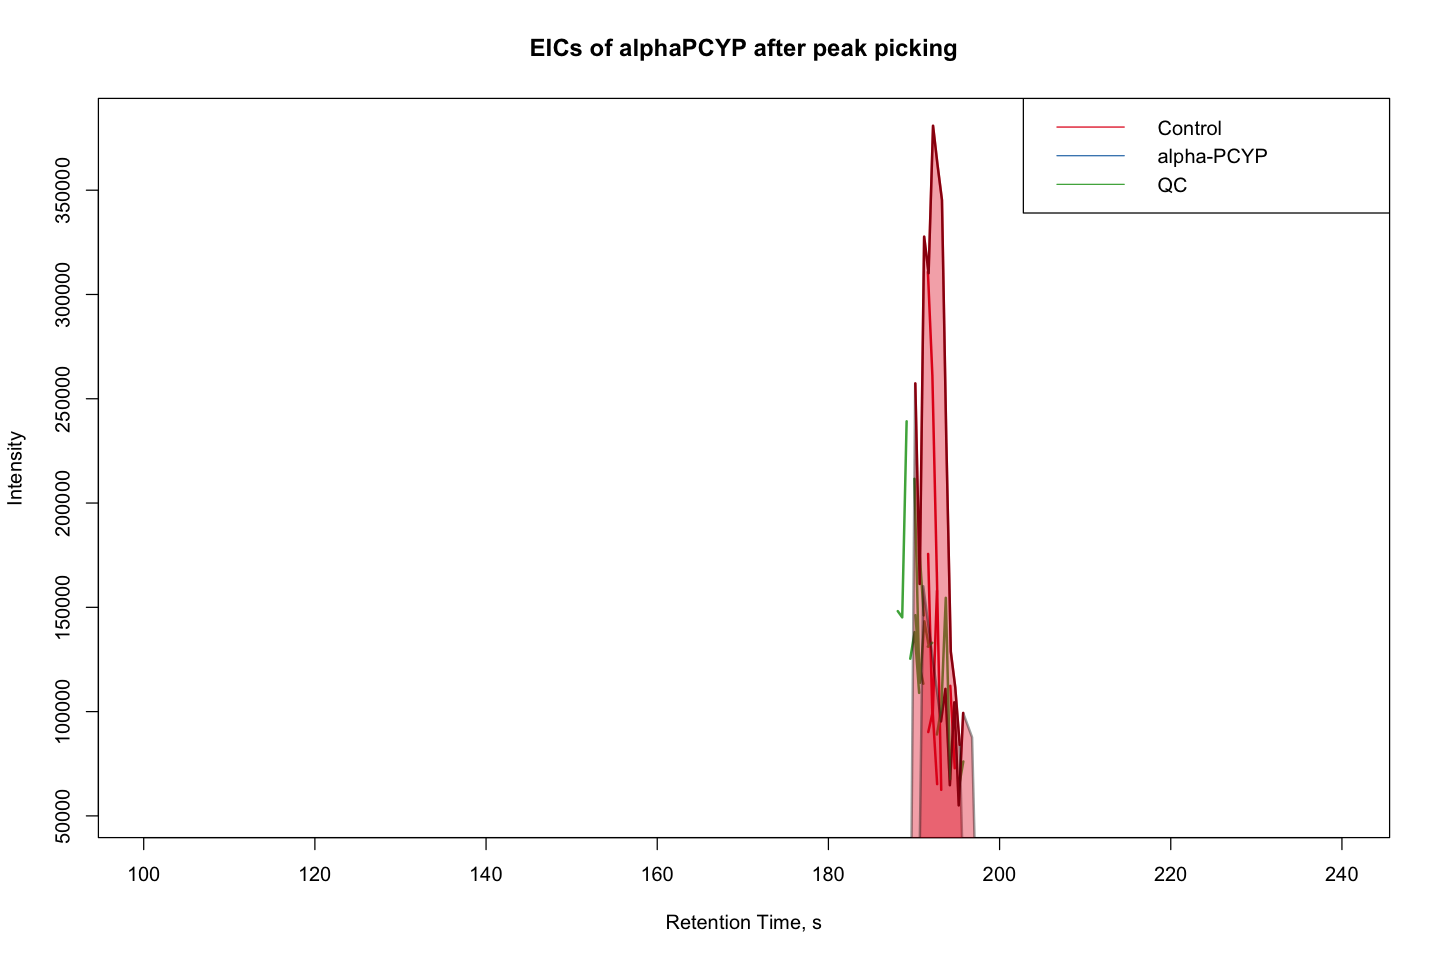

In [21]:
## Plot alpha-PCYP after peak picking (m/z 272.2008, 314 s)
alphaPCYP.picked <- chromatogram(set, mz = c(272.2000, 272.2015), rt = c(100, 240)) 

plot(alphaPCYP.picked, col = group.colours[alphaPCYP.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(alphaPCYP.picked)[, "sample"]],
     main = bquote(bold("EICs of alphaPCYP"*" after peak picking")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Retention Time Correction

In [22]:
suppressMessages({
    
    set <- adjustRtime(set, param = ObiwarpParam(binSize = 0.6))
    set <- dropAdjustedRtime(set)

    pdp <- PeakDensityParam(sampleGroups = set$sample_group, bw = 1.5)
    set <- groupChromPeaks(set, param = pdp)

    ## Define subset alignment options and perform the alignment
    pgp <- PeakGroupsParam(minFraction = 0.8, 
                           subset = which(set$sample_group == "QC"),
                           subsetAdjust = "average", span = 0.2)
    set <- adjustRtime(set, param = pgp)
    
})

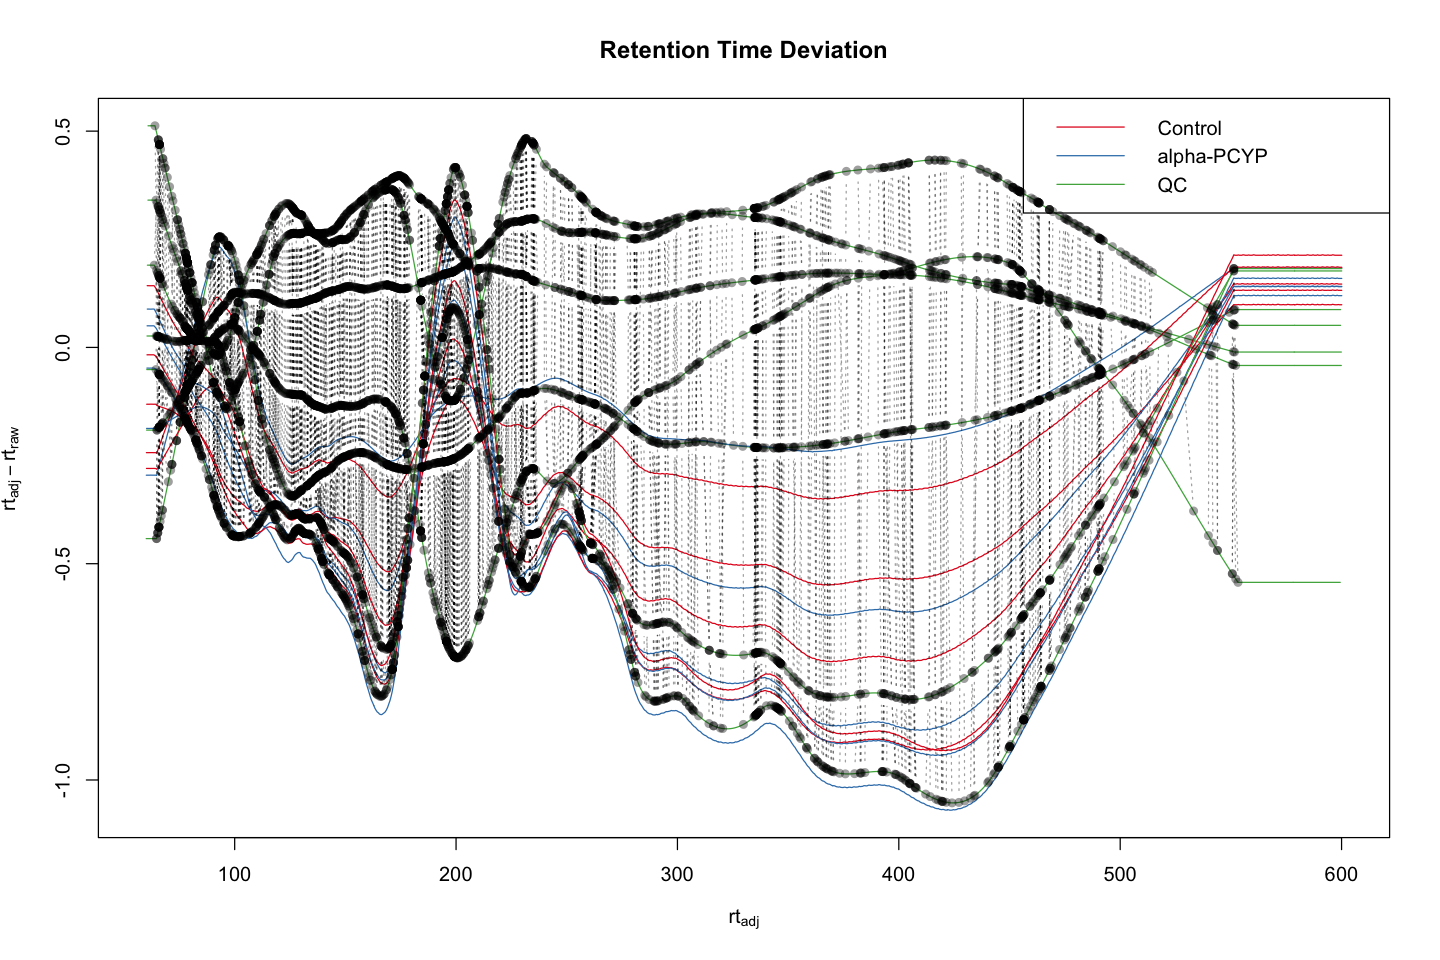

In [23]:
## Plot difference of adjusted to raw retention time.
plotAdjustedRtime(set, col = group.colours[set$sample_group], 
                  main = "Retention Time Deviation")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

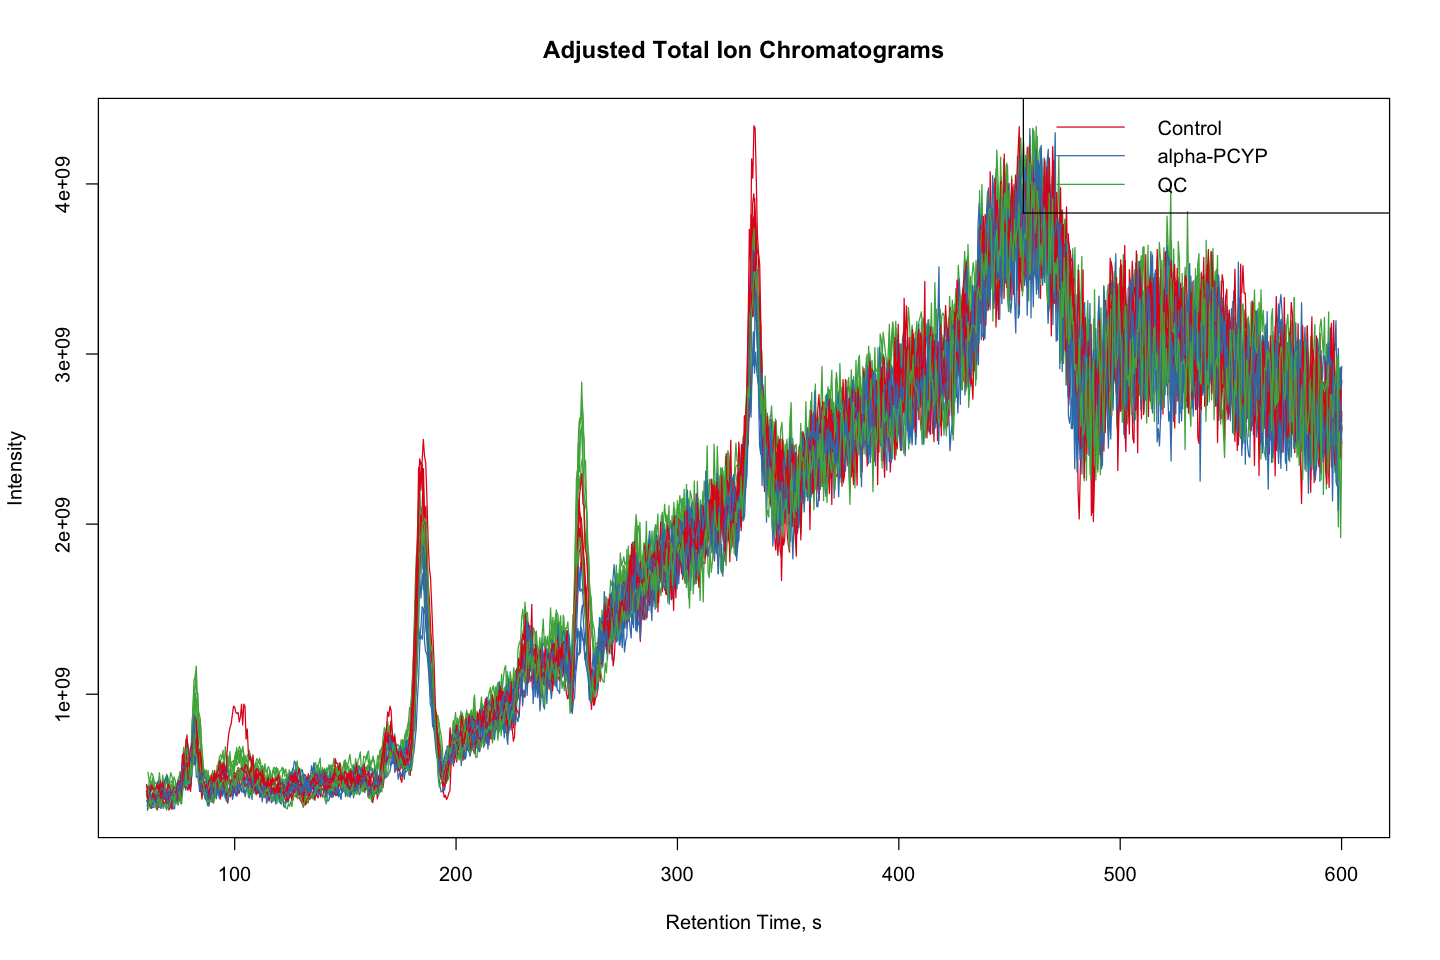

In [24]:
## Get the retention time-adjusted total ion chromatograms.
tics.corr <- chromatogram(set, aggregationFun = "sum")

plot(tics.corr, col = group.colours[tics.corr$sample_group], 
     peakType = "none", main = "Adjusted Total Ion Chromatograms", 
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), col = group.colours, lty = 1)

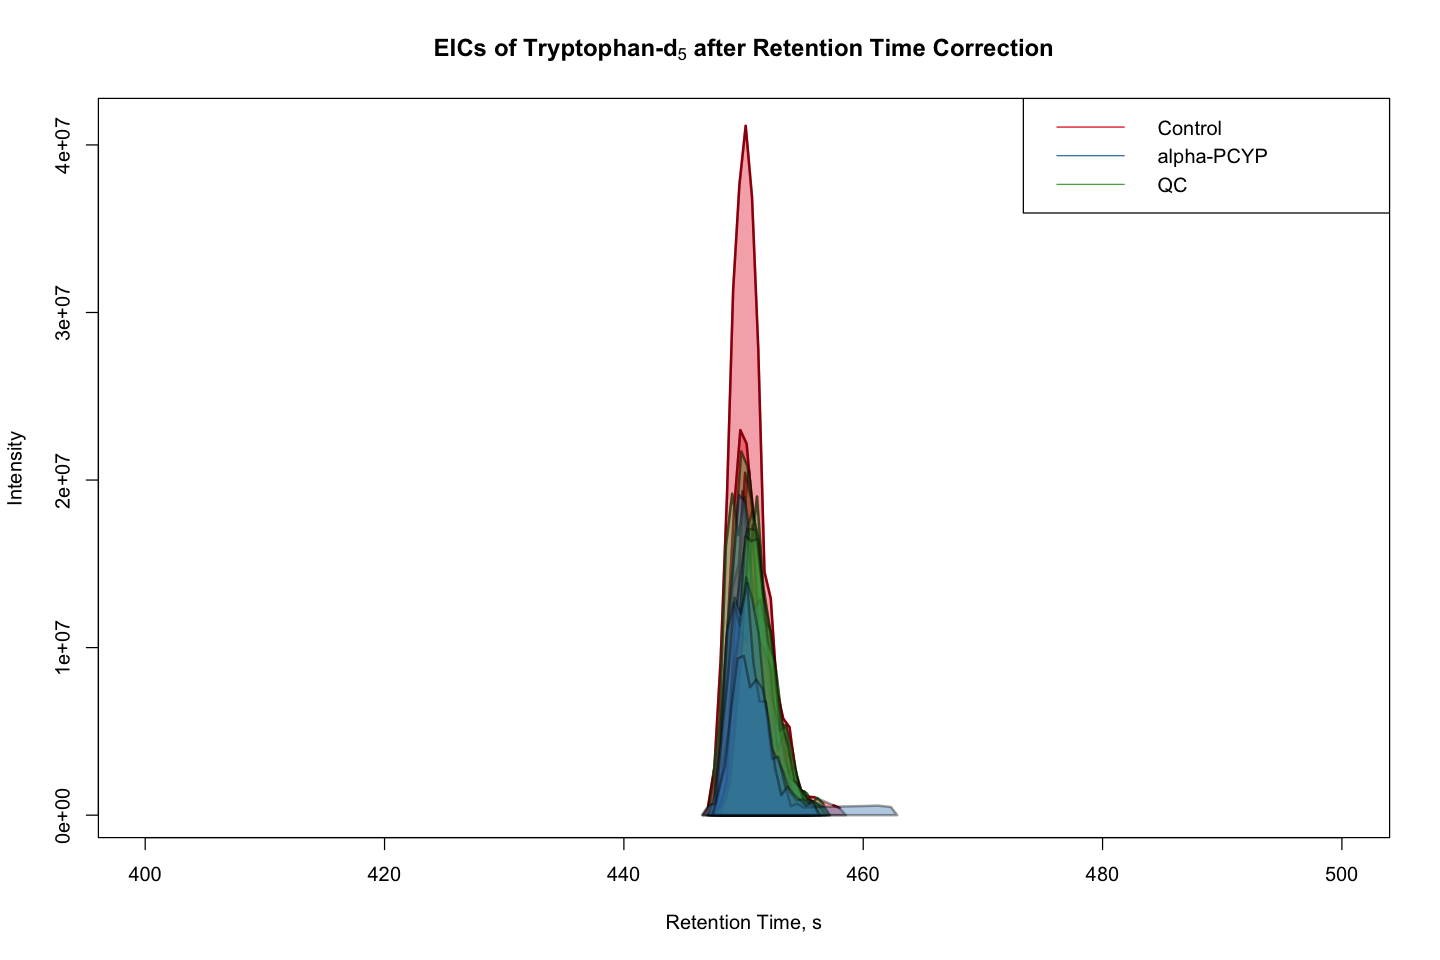

In [25]:
## Plot tryptophan-d5 after retention time correction (m/z 210.1291, 168 s)
trpd5.corr <- chromatogram(set, mz = c(210.1281, 210.1301), rt = c(400, 500))

plot(trpd5.corr, col = group.colours[trpd5.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(trpd5.corr)[, "sample"]],
     peakPch = 16, main = bquote(bold("EICs of Tryptophan-d"[5]*" after Retention Time Correction")),
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

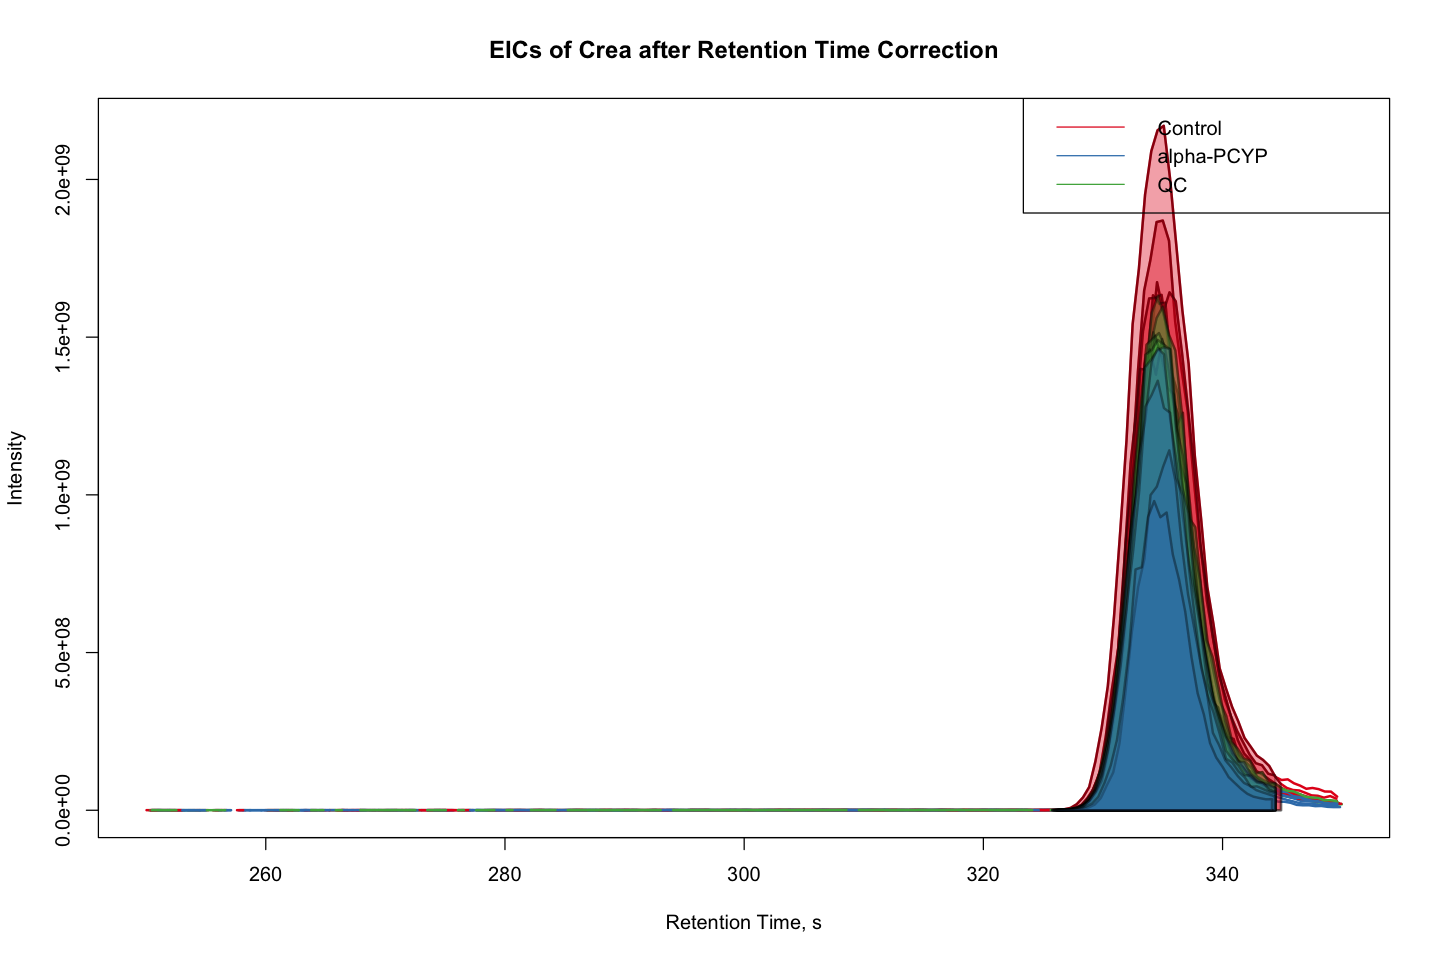

In [26]:
## Plot Crea after after retention time correction (m/z 114.0665, 287 s)
crea.corr <- chromatogram(set, mz = c(114.0645, 114.0685), rt = c(250, 350))

plot(crea.corr, col = group.colours[crea.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(crea.corr)[, "sample"]],
     peakPch = 16, main = bquote(bold("EICs of Crea after Retention Time Correction")),
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

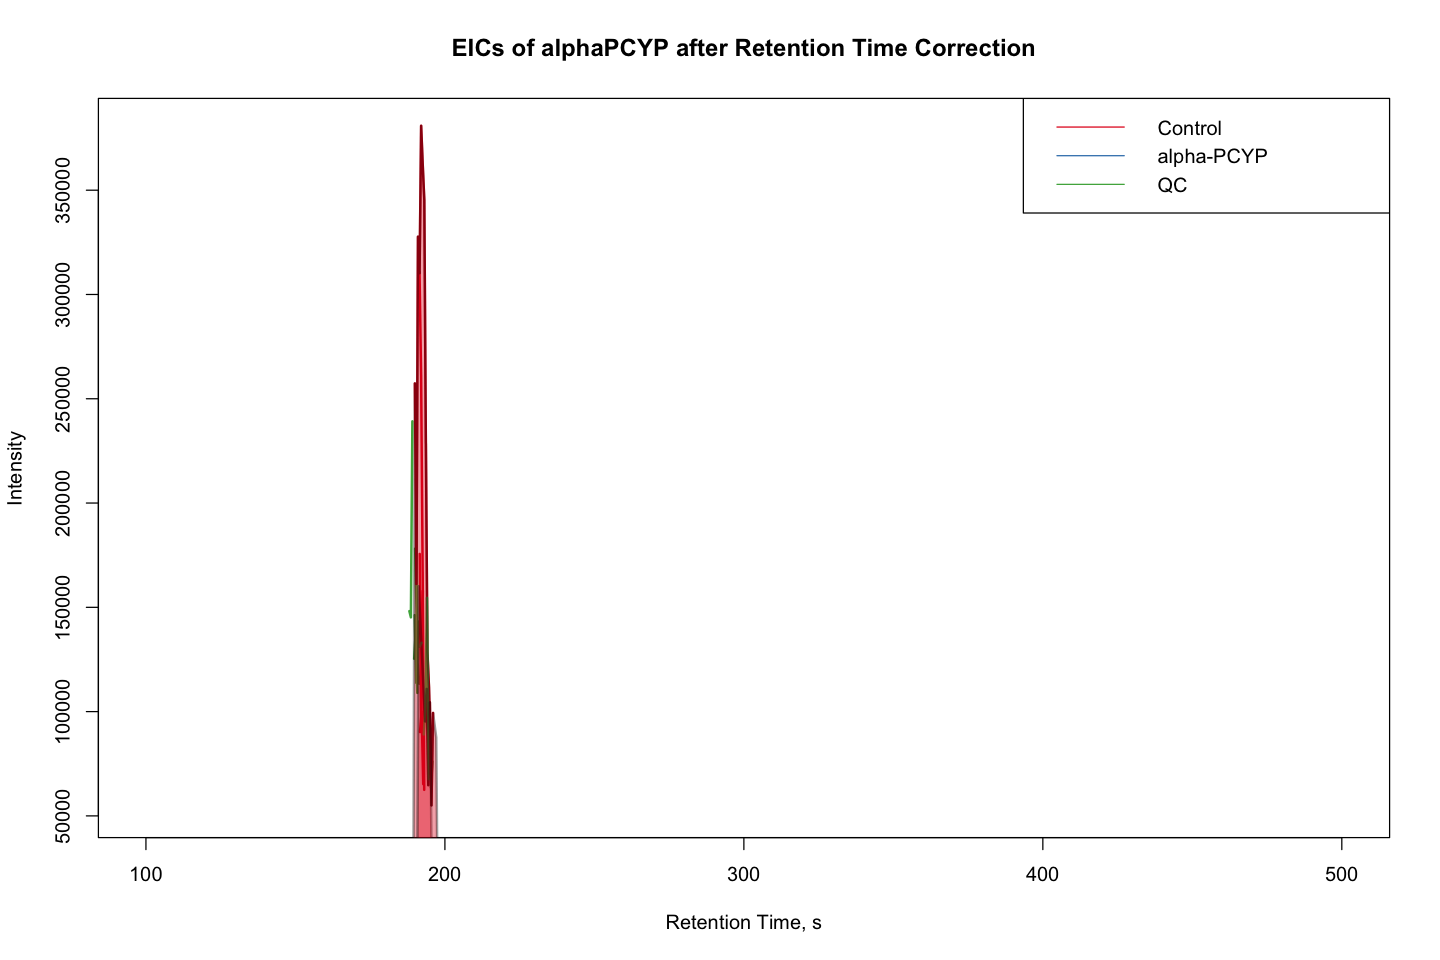

In [28]:
## Plot alpha-PCYP after retention time correction (m/z 272.2008, 314 s)
alphaPCYP.corr <- chromatogram(set, mz = c(272.2000, 272.2015), rt = c(100, 500))

plot(alphaPCYP.corr, col = group.colours[alphaPCYP.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(alphaPCYP.corr)[, "sample"]],
     peakPch = 16, main = bquote(bold("EICs of alphaPCYP"*" after Retention Time Correction")),
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Peak Grouping

In [29]:
suppressMessages(
    
    set <- groupChromPeaks(set, param = pdp)
    
)

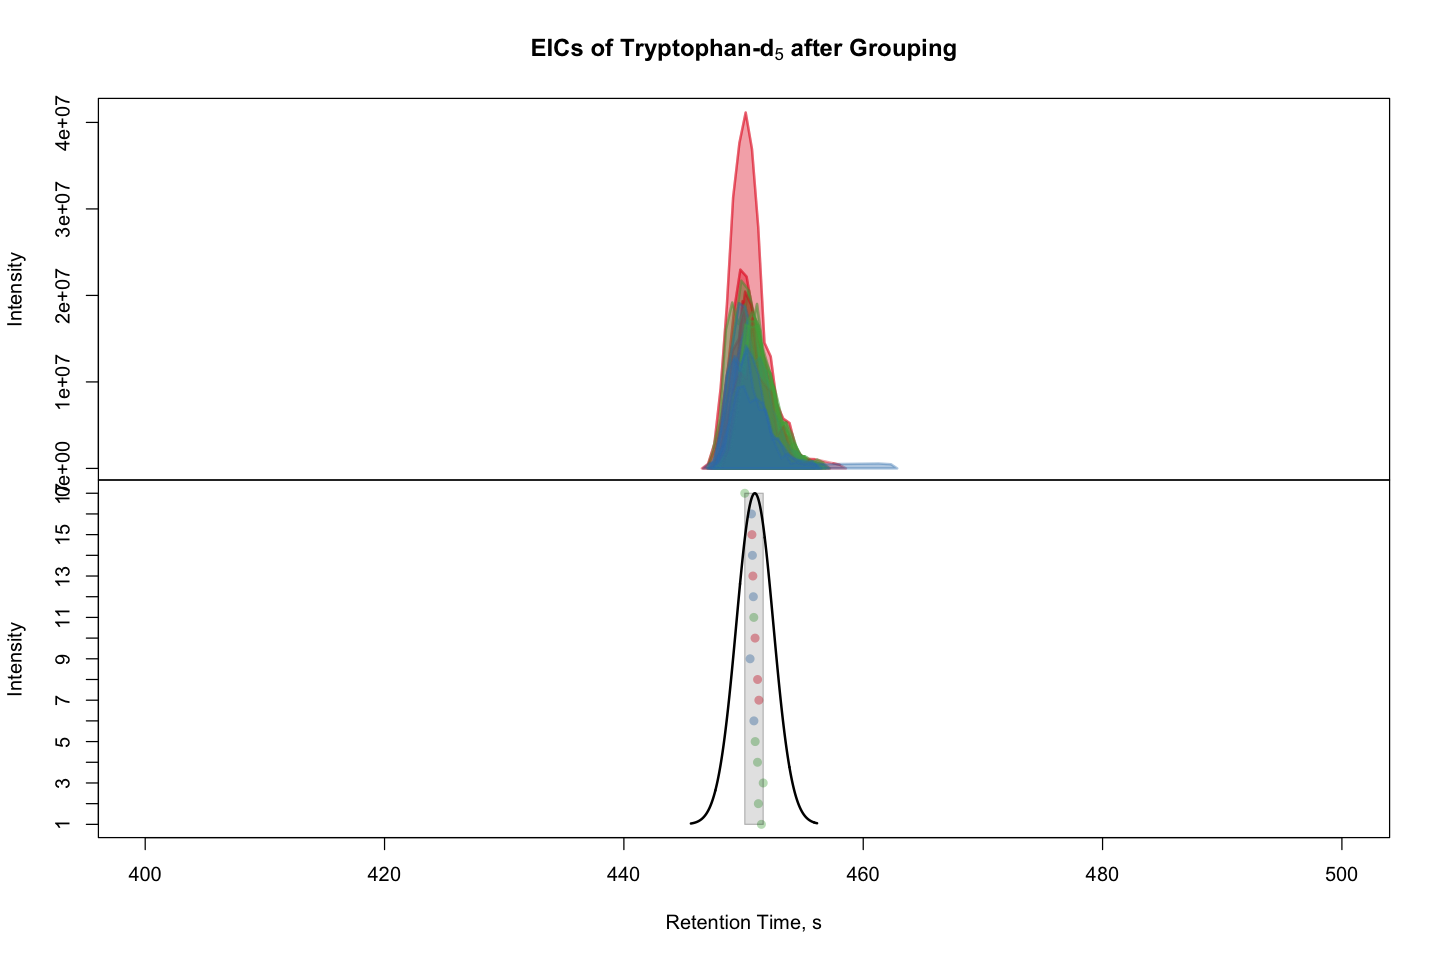

In [30]:
## Plot trp-d5 after peak grouping
trpd5.grouped <- chromatogram(set, mz = c(210.1281, 210.1301), rt = c(400, 500))

## Define the parameters for the peak density method
plotChromPeakDensity(trpd5.grouped, col = sample.colours, param = pdp, lwd = 2,
                     peakBg = sample.colours[chromPeaks(trpd5.grouped)[, "sample"]],
                     peakCol = sample.colours[chromPeaks(trpd5.grouped)[, "sample"]],
                     peakPch = 16, main = bquote(bold("EICs of Tryptophan-d"[5]*" after Grouping")),
                     xlab = "Retention Time, s", ylab = "Intensity")

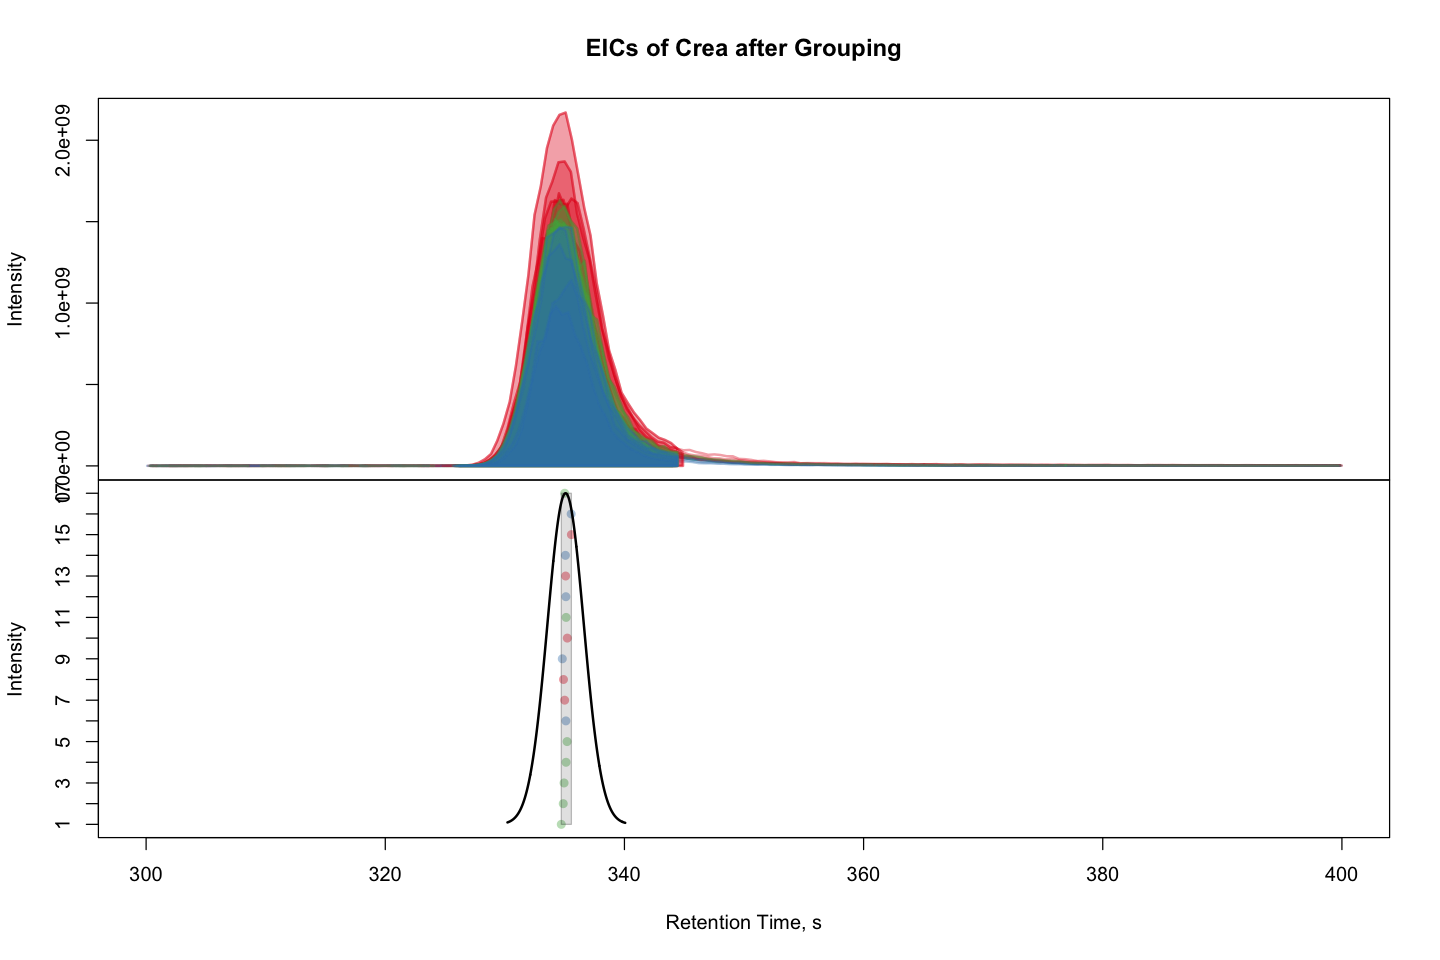

In [31]:
## Plot Crea after peak grouping
crea.grouped <- chromatogram(set, mz = c(114.0645, 114.0685), rt = c(300, 400))

## Define the parameters for the peak density method
plotChromPeakDensity(crea.grouped, col = sample.colours, param = pdp, lwd = 2,
                     peakBg = sample.colours[chromPeaks(crea.grouped)[, "sample"]],
                     peakCol = sample.colours[chromPeaks(crea.grouped)[, "sample"]],
                     peakPch = 16, main = bquote(bold("EICs of Crea after Grouping")),
                     xlab = "Retention Time, s", ylab = "Intensity")

# Peak Filling

In [32]:
suppressMessages(    
     
    set <- fillChromPeaks(set, param = ChromPeakAreaParam())
    
)

ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'param' bei der Methodenauswahl für Funktion 'fillChromPeaks': konnte Funktion "ChromPeakAreaParam" nicht finden


# Postprocessing


# Annotation of Adducts and Isotopes

In [33]:
## Summarise experiment
results <- quantify(set, value = "into")
class(results)

[1] "SummarizedExperiment"
attr(,"package")
[1] "SummarizedExperiment"

In [34]:
rowData(results) %>%
head()

DataFrame with 6 rows and 12 columns
           mzmed     mzmin     mzmax     rtmed     rtmin     rtmax    npeaks
       <numeric> <numeric> <numeric> <numeric> <numeric> <numeric> <numeric>
FT0001   60.0817   60.0817   60.0818   402.826   402.261   404.938         8
FT0002   61.0406   61.0249   61.0563   256.914   256.030   258.014        26
FT0003   62.0407   62.0376   62.0439   256.978   256.030   257.443        34
FT0004   62.0610   62.0609   62.0610   170.959   170.657   171.569        17
FT0005   63.0448   63.0448   63.0448   256.745   256.094   257.340        17
FT0006   64.0167   64.0167   64.0167   490.546   489.933   491.020        16
       alpha.PCYP   Control        QC            peakidx  ms_level
        <numeric> <numeric> <numeric>             <list> <integer>
FT0001          1         2         5  927,2029,4315,...         1
FT0002          5         5         7  952,1844,2082,...         1
FT0003          5         5         7  794, 799,1885,...         1
FT0004      

In [35]:
## Add classic feature names
rowData(results)$label <- paste0("M",round(rowData(results)$mzmed,0),
                           "T", round(rowData(results)$rtmed,0))
rowData(results) %>%
head()

DataFrame with 6 rows and 13 columns
           mzmed     mzmin     mzmax     rtmed     rtmin     rtmax    npeaks
       <numeric> <numeric> <numeric> <numeric> <numeric> <numeric> <numeric>
FT0001   60.0817   60.0817   60.0818   402.826   402.261   404.938         8
FT0002   61.0406   61.0249   61.0563   256.914   256.030   258.014        26
FT0003   62.0407   62.0376   62.0439   256.978   256.030   257.443        34
FT0004   62.0610   62.0609   62.0610   170.959   170.657   171.569        17
FT0005   63.0448   63.0448   63.0448   256.745   256.094   257.340        17
FT0006   64.0167   64.0167   64.0167   490.546   489.933   491.020        16
       alpha.PCYP   Control        QC            peakidx  ms_level       label
        <numeric> <numeric> <numeric>             <list> <integer> <character>
FT0001          1         2         5  927,2029,4315,...         1     M60T403
FT0002          5         5         7  952,1844,2082,...         1     M61T257
FT0003          5         5    

In [36]:
assay(results) %>% 
head()

pQC_1.mzXML pQC_2.mzXML pQC_3.mzXML pQC_4.mzXML pQC_5.mzXML
FT0001     9164757  7097125             NA     8269074     8854385
FT0002 12977186839  1711602    12097463816 11683795509 11125374753
FT0003   125114637 80402796       77704010    75265771    71706404
FT0004     3862453  3550896        3417955     4251034     3656461
FT0005    24173697 24442641       20436976    22206382    20061842
FT0006    34508729 33363772       33413844    36580186    37478374
       24h_Urine_Rat_Control_5.mzXML 24h_Urine_Rat_PCYP_4.mzXML
FT0001   11847770                    22104665                  
FT0002 6798500163                     2879189                  
FT0003   41504627                    65809572                  
FT0004    3515885                     5965446                  
FT0005   11524636                    18595109                  
FT0006   32875007                    50405294                  
       24h_Urine_Rat_PCYP_1.mzXML 24h_Urine_Rat_Control_3.mzXML
FT0001         NA                         NA                   
FT0002 8603154143                 4364048457                   
FT0003   52632982                   26359025                   
FT0004    5127446                    1642131                   
FT0005   15181680                    7032023                   
FT0006   42412079                   41233060                   
       24h_Urine_Rat_PCYP_2.mzXML pQC_6.mzXML 24h_Urine_Rat_Control_2.mzXML
FT0001       NA                           NA          NA                   
FT0002  2565895                   9486768590  7003706086                   
FT0003 50923471                     59011540    43066010                   
FT0004  5388449                      4103837     3706580                   
FT0005 14811440                     17628962    12238609                   
FT0006       NA                     43697370    44156758                   
       24h_Urine_Rat_PCYP_5.mzXML 24h_Urine_Rat_Control_4.mzXML
FT0001       NA                           NA                   
FT0002  2245072                   5461989108                   
FT0003 63147688                     34430470                   
FT0004  6884085                      3592818                   
FT0005 18091099                      9441898                   
FT0006 48163635                     37316481                   
       24h_Urine_Rat_PCYP_3.mzXML 24h_Urine_Rat_Control_1.mzXML pQC_7.mzXML
FT0001   14045844                         NA                       9495524 
FT0002 9701148800                 4465128130                    9054591364 
FT0003   62804743                   29038256                      55444832 
FT0004    4897460                    1866664                       4275756 
FT0005   17604287                    8120040                      16609654 
FT0006   47368216                   34000662                      49566127

In [37]:
## Perform annotation using CAMERA
suppressMessages({
    
    camera <- set %>%
              as("xcmsSet") %>%
              CAMERA::annotate(polarity  = "positive") %>%
              getPeaklist() %>%
              dplyr::select(isotopes, adduct, pcgroup)
    
})

## Save annotation results in SummarizedExperiment class
rowData(results)$isotopes <- camera$isotopes
rowData(results)$adduct <- camera$adduct
rowData(results)$pcgroup <- camera$pcgroup

Start grouping after retention time.
Created 129 pseudospectra.
Generating peak matrix!
Run isotope peak annotation
 % finished: 10  20  30  40  50  60  70  80  90  100  
Found isotopes: 239 
Start grouping after correlation.
Generating EIC's .. 

Calculating peak correlations in 129 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  

Calculating graph cross linking in 129 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  
New number of ps-groups:  818 
xsAnnotate has now 818 groups, instead of 129 
Generating peak matrix for peak annotation!

Calculating possible adducts in 818 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  


# Scaling

Before log10 transformation, every NA in the data matrix is replaced by the surrogate LOD according to Wehrens et al. at DOI: 10.1007/s11306-016-1015-8. The surrogate LOD is the lowest area that was measured during the analysis.

In [38]:
assays(results)

List of length 1
names(1): raw

In [39]:
# Replacing 0s with surrogate LOD
lod <- assay(results, "raw")[is.na(assay(results, "raw")) == FALSE] %>%
       min()
assay(results, "raw")[is.na(assay(results, "raw"))] <- lod

# Create assay results after log10 transformation
assay(results, "scaled") <- assay(results, "raw") %>%
                            log10()

In [40]:
assays(results)

List of length 2
names(2): raw scaled

In [41]:
results %>%
assay("scaled") %>%
head()

pQC_1.mzXML pQC_2.mzXML pQC_3.mzXML pQC_4.mzXML pQC_5.mzXML
FT0001  6.962121   6.851082     5.365922    6.917457    6.947158  
FT0002 10.113181   6.233403    10.082694   10.067584   10.046315  
FT0003  8.097308   7.905271     7.890443    7.876598    7.855558  
FT0004  6.586863   6.550338     6.533766    6.628495    6.563061  
FT0005  7.383343   7.388148     7.310417    7.346478    7.302371  
FT0006  7.537929   7.523275     7.523926    7.563246    7.573781  
       24h_Urine_Rat_Control_5.mzXML 24h_Urine_Rat_PCYP_4.mzXML
FT0001 7.073637                      7.344484                  
FT0002 9.832413                      6.459270                  
FT0003 7.618097                      7.818289                  
FT0004 6.546035                      6.775643                  
FT0005 7.061627                      7.269399                  
FT0006 7.516866                      7.702476                  
       24h_Urine_Rat_PCYP_1.mzXML 24h_Urine_Rat_Control_3.mzXML
FT0001 5.365922                   5.365922                     
FT0002 9.934658                   9.639890                     
FT0003 7.721258                   7.420929                     
FT0004 6.709901                   6.215408                     
FT0005 7.181320                   6.847080                     
FT0006 7.627490                   7.615246                     
       24h_Urine_Rat_PCYP_2.mzXML pQC_6.mzXML 24h_Urine_Rat_Control_2.mzXML
FT0001 5.365922                   5.365922    5.365922                     
FT0002 6.409239                   9.977118    9.845328                     
FT0003 7.706918                   7.770937    7.634135                     
FT0004 6.731464                   6.613190    6.568973                     
FT0005 7.170597                   7.246227    7.087732                     
FT0006 5.365922                   7.640455    7.644997                     
       24h_Urine_Rat_PCYP_5.mzXML 24h_Urine_Rat_Control_4.mzXML
FT0001 5.365922                   5.365922                     
FT0002 6.351230                   9.737351                     
FT0003 7.800357                   7.536943                     
FT0004 6.837846                   6.555435                     
FT0005 7.257465                   6.975059                     
FT0006 7.682719                   7.571901                     
       24h_Urine_Rat_PCYP_3.mzXML 24h_Urine_Rat_Control_1.mzXML pQC_7.mzXML
FT0001 7.147548                   5.365922                      6.977519   
FT0002 9.986823                   9.649834                      9.956869   
FT0003 7.797992                   7.462971                      7.743861   
FT0004 6.689971                   6.271066                      6.631013   
FT0005 7.245618                   6.909558                      7.220361   
FT0006 7.675487                   7.531487                      7.695185

# Normalisation

In [50]:
## Define function to calculate ppm deviation
ppm <- function(x,y) {

    return(10^6 * (x - y) / y)

}

## Define function to identify row of compound
identify <- function(data, mz, rt, ppmlim, rtlim) {

    delta.mz <- abs(mapply(ppm, x = data$mzmed, y = mz))
    delta.rt <- abs(data$rtmed - rt)
    return(which(delta.mz < ppmlim & delta.rt < rtlim))
    
}

In [51]:
## Identify rownumber of internal standard tryptophan-d5
crea <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 114.0666, rt = 335, 5, 10)

In [53]:
## Normalise data to internal standard
norm.is <- function(x, is){x/x[is]}
assay(results, "norm") <- apply(assay(results, "scaled"),2, norm.is, is = crea)

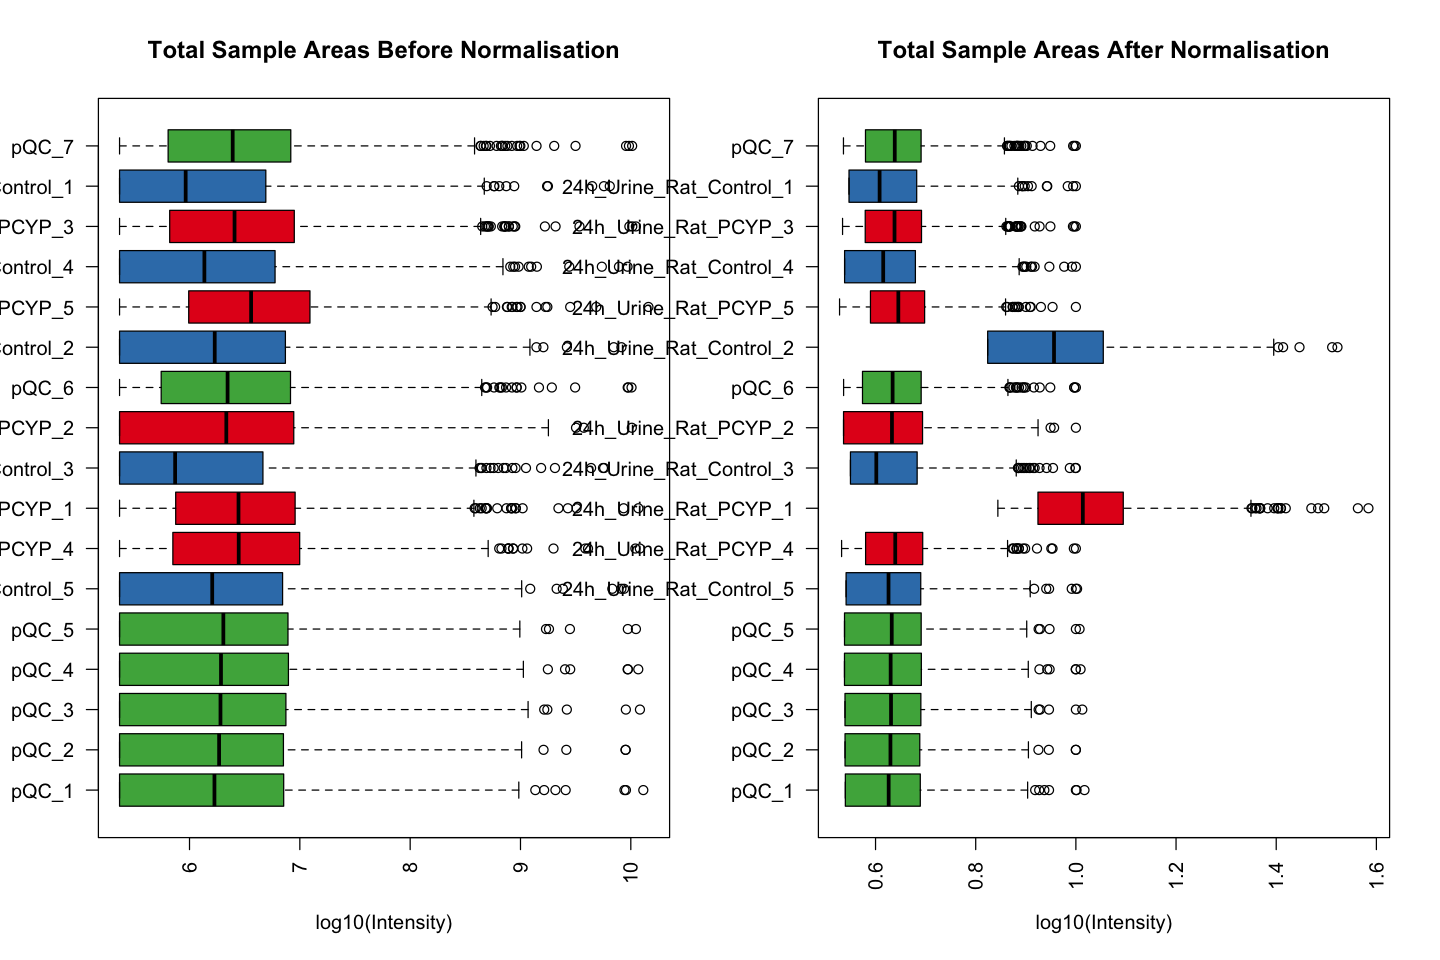

In [54]:
## Compare normalised and unnormalised data
par(mfrow = c(1,2))

results %>%
assay("scaled") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Normalisation", las = 2)

results %>%
assay("norm") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Normalisation", las = 2)

# Batch correction

In [55]:
## Define function to perform batch correction
batchCorrection <-function(area, order, group, output = c("df", "corr")) {
        
    df <- data.frame(order = order, area = area)
    model <- lm(area ~ order, data = df[group == "QC",])
    df$pred <- predict(model, newdata = df)
    df$corr <- df$corr <- df$area - df$pred + mean (df$area)
    return(switch(output, df = df, corr = df$corr))
    
}

In [56]:
## Filter features by detectability in QC samples
#results.filtered <- results[rowData(results)$QC == 9,]

In [57]:
## Perform batch correction
assay(results, "batchcorr",
      withDimnames = FALSE) <- apply(assay(results, "scaled"), 
                                     1, batchCorrection, 
                                     order = set$sample_order, 
                                     group = set$sample_group, 
                                     output = "corr") %>%
                                     t()

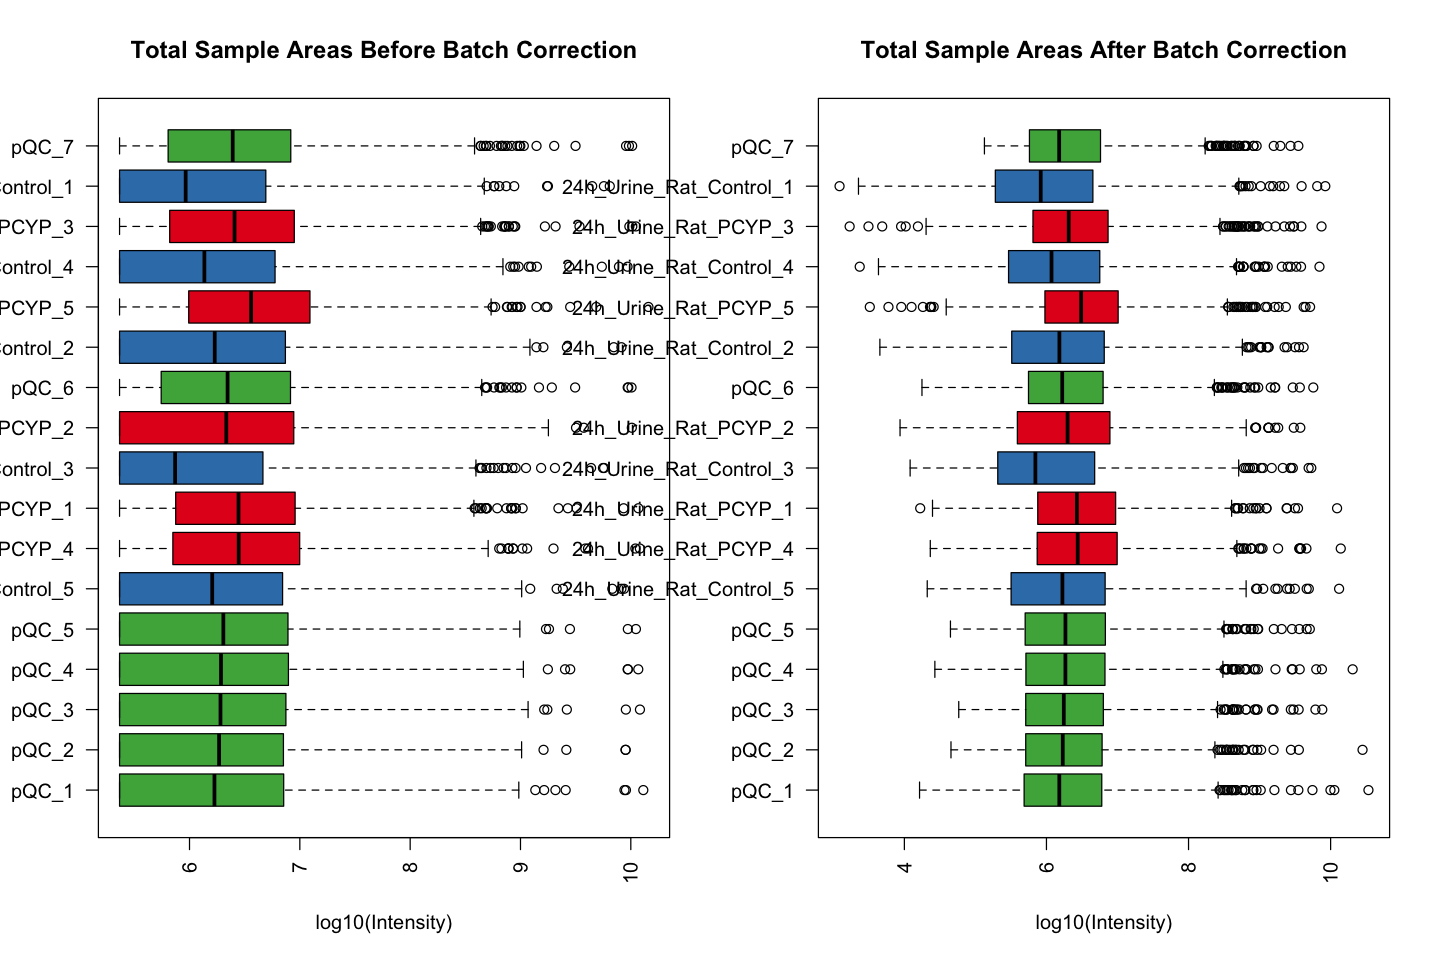

In [58]:
## Compare batch-corrected and uncorrected total sample areas
par(mfrow = c(1,2))

results %>%
assay("scaled") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Batch Correction", las = 2)

results %>%
assay("batchcorr") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Batch Correction", las = 2)

In [59]:
## Compare batch-corrected and uncorrected areas of compounds
df <- batchCorrection(assay(results, "scaled")[51,], 
                      set$sample_order, set$sample_group, "df")

## Perform regression using corrected values
lm <- lm(area ~ order, data = df[results$sample_group == "QC",])
lm.new <- lm(corr ~ order, data = df[results$sample_group == "QC",])

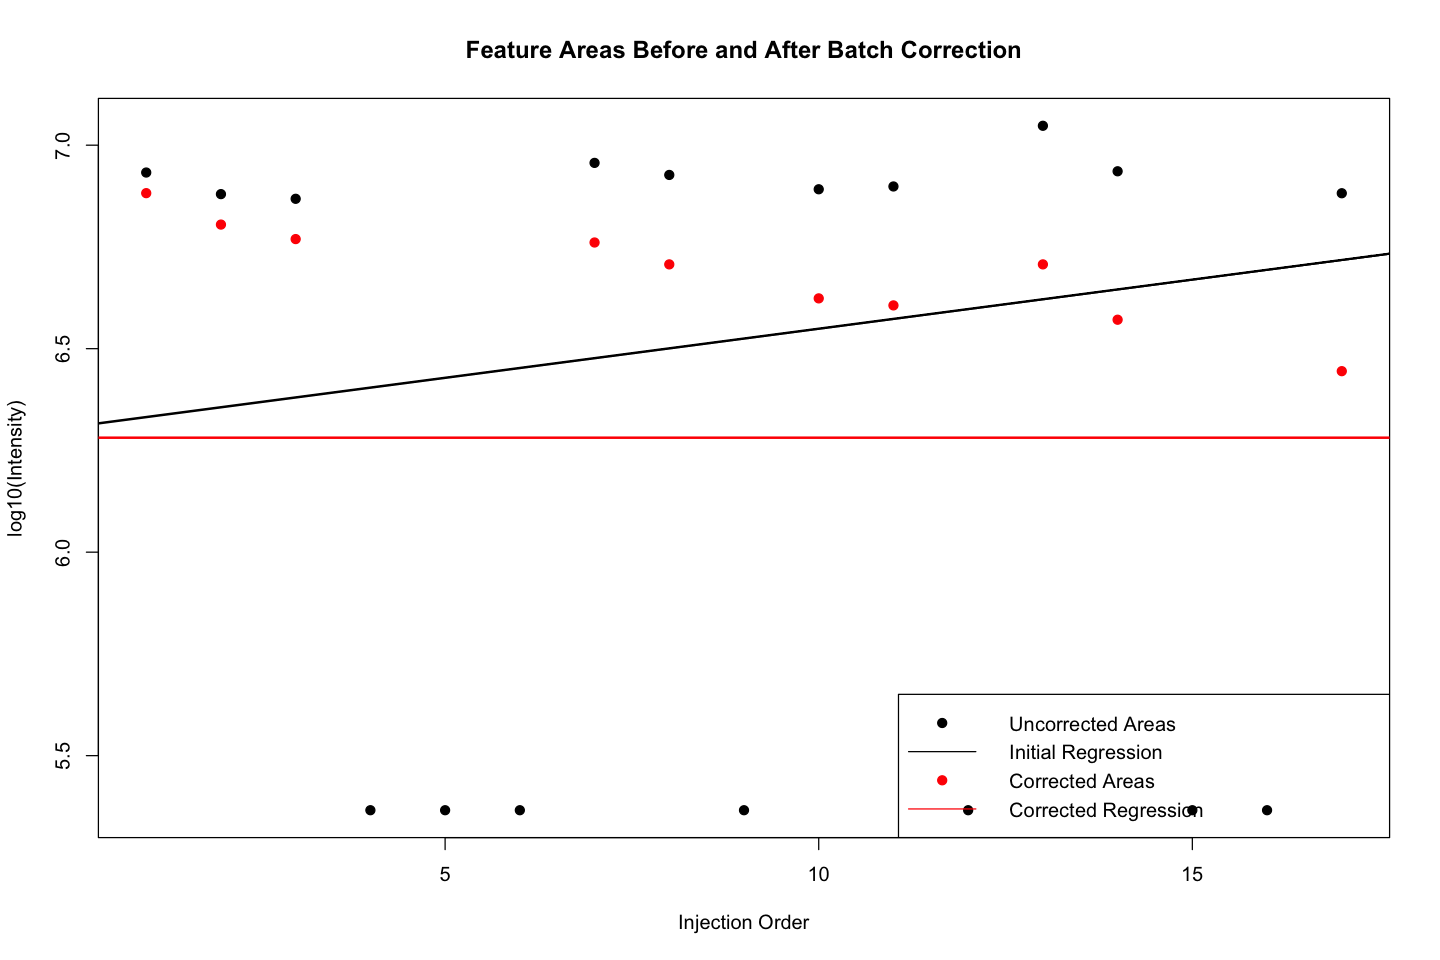

In [60]:
## Plot uncorrected and corrected models and data points
plot(df$order, df$area, col = "black", pch = 19,
     xlab = "Injection Order", ylab = "log10(Intensity)", 
     main = "Feature Areas Before and After Batch Correction")
abline(lm, lwd = 2, col = "black")
points(df$order, df$corr, col = "red", pch = 19)
abline(lm.new, lwd = 2, col = "red")
legend("bottomright", lty = c(NA,1,NA,1), pch=c(19,NA,19,NA),
       legend = c("Uncorrected Areas", "Initial Regression", 
                  "Corrected Areas", "Corrected Regression"), 
       col = c("black", "black", "red", "red"))